# TODO: redo the methods here since I changed the API a little

The goal was to examine the analytic zernike relationships that I expected and see how well they hold up. Here is my problem: there are all sorts of extra leakages! By far the most worrying aspect is that the SLOPE of the relation between rzero and other parameters changes with the zernike -- at near zero, the rzero does not interact, but as the perturbations increase, it becomes linear, and then parabolic. In other words, rzero is not divorced from some of these terms and couples through the zernikes! That sounds massively irritating!

In [3]:
%matplotlib inline
from sklearn import cross_validation
import numpy as np
import os
import pandas as pd
from WavefrontPSF.decamutil import decaminfo
dec = decaminfo()

path = '/Users/cpd/Desktop/ComboMeshes-old/'
path_out = '/Users/cpd/Desktop/ComboMeshes2/'
mesh_name = 'Science-20140212s2-v1i2_All'#'Science-20121120s1-v1i2_All'
dTrains = []
dTests = []
dVals = []
fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_val.dat'):
    
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    dTrains = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    dTests = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    dVals = pd.read_csv(valName)

    
else:
    fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
    fileName = path + fileTitle + '.dat'
    dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),('z','float'),('w','float')])
    dTrain_base_indx, dTest_indx = cross_validation.train_test_split(np.arange(len(dataPoints)))
    # divide the dTrain_base_indx into dTrain_indx and dVal_indx
    dTrain_indx, dVal_indx = cross_validation.train_test_split(np.arange(len(dTrain_base_indx)))
    
    sensor = dataPoints['Sensor']
    # convert sensor to chip id
    x = dataPoints['x']
    y = dataPoints['y']
    
    columns = ['x', 'y', 'ccdnum']
    ccdnum = [dec.infoDict[sensor_i]['CCDNUM']
              for sensor_i in sensor]
    coords = np.array([x, y, ccdnum]).T
    dTests = coords[dTest_indx]
    dTrains = coords[dTrain_base_indx][dTrain_indx]
    dVals = coords[dTrain_base_indx][dVal_indx]
    for zi in range(4, 12):
        fileTitle = 'z{0}'.format(zi) + 'Mesh_' + mesh_name
        fileName = path + fileTitle + '.dat'
        zkey = 'z{0}'.format(zi)
        wkey = 'w{0}'.format(zi)
        columns += [zkey, wkey]
        
        dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),
                                                 (zkey, 'float'),(wkey,'float')])

        dTests = np.hstack((dTests,
                            dataPoints[zkey][dTest_indx][:, np.newaxis],
                            dataPoints[wkey][dTest_indx][:, np.newaxis]))
        dTrains = np.hstack((dTrains,
                            dataPoints[zkey][dTrain_base_indx][dTrain_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dTrain_indx][:, np.newaxis]))
        dVals = np.hstack((dVals,
                            dataPoints[zkey][dTrain_base_indx][dVal_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dVal_indx][:, np.newaxis]))
        # save!
        trainName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_train.dat'
        np.savetxt(trainName, dataPoints[dTrain_base_indx][dTrain_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        testName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_test.dat'
        np.savetxt(testName, dataPoints[dTest_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        valName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_val.dat'
        np.savetxt(valName, dataPoints[dTrain_base_indx][dVal_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])

    # save!
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    df = pd.DataFrame(dTrains, columns=columns)
    df.to_csv(trainName)
    dTrains = df
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    df = pd.DataFrame(dTests, columns=columns)
    df.to_csv(testName)
    dTests = df
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    df = pd.DataFrame(dVals, columns=columns)
    df.to_csv(valName)
    dVals = df

In [5]:
from WavefrontPSF.donutengine import DECAM_Model_Wavefront
WF = DECAM_Model_Wavefront(dTrains)
_ = WF.get_psf_stats(dTests['x'], dTests['y'])
WF.data.to_csv('/Volumes/Seagate/data.csv')
np.save('/Volumes/Seagate/data_cutouts', WF.cutouts)

TypeError: interpolate() takes exactly 2 arguments (3 given)

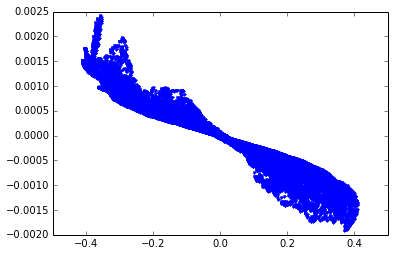

In [25]:
plt.plot(WF.data['z10'], WF.data['delta1'], '.')

Now I have the analytic equations that relate input zernikes to output moments. I don't expect them to be 100 percent correspondences, however, because measurements of the moments are weighted. Additionally, there are effects from the spider that depend on focal plane position, and there is also a kolmogorov convolution in there, too.

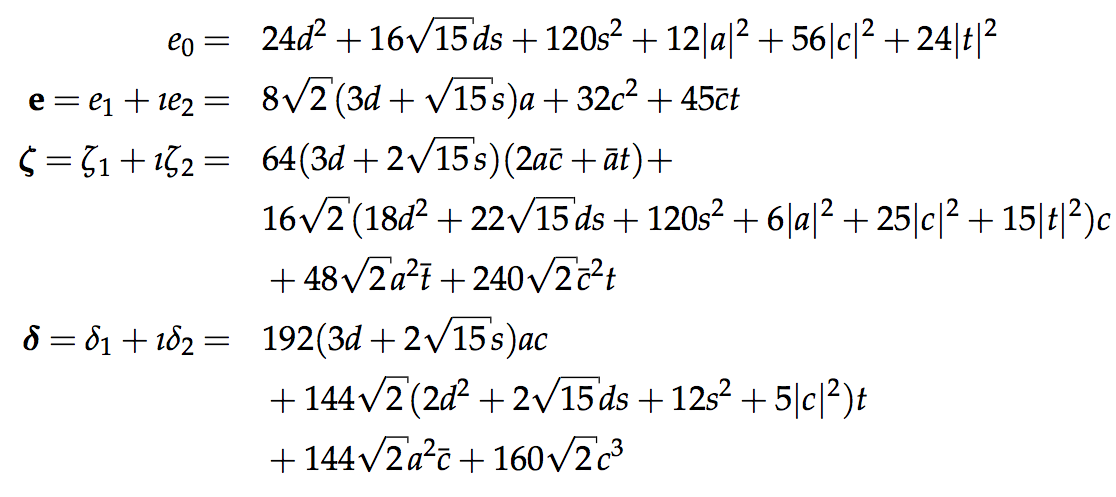

In [26]:
from IPython.display import display, Image
im = Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/eqs.png')
display(im)

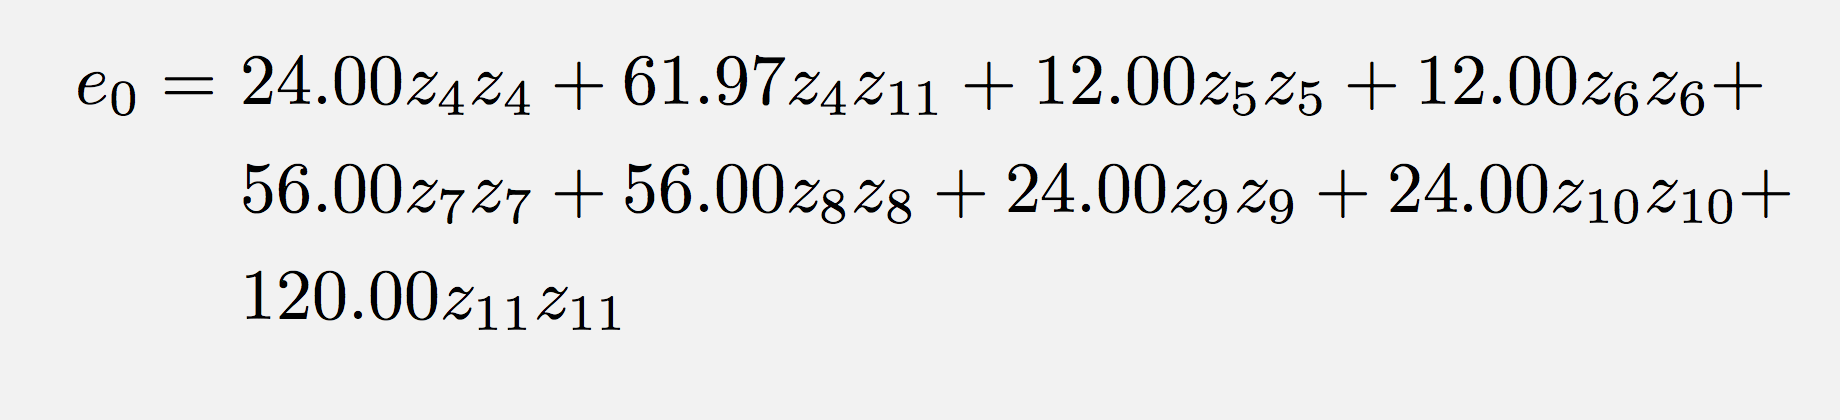

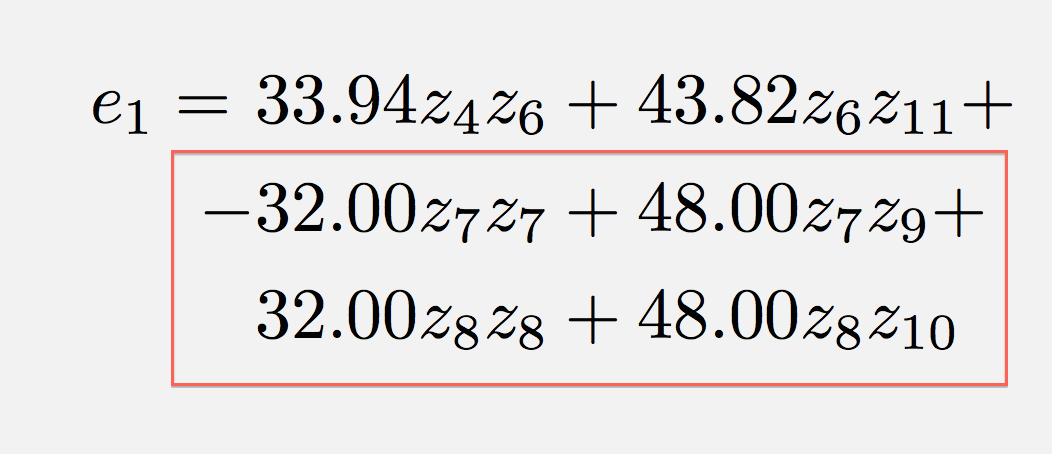

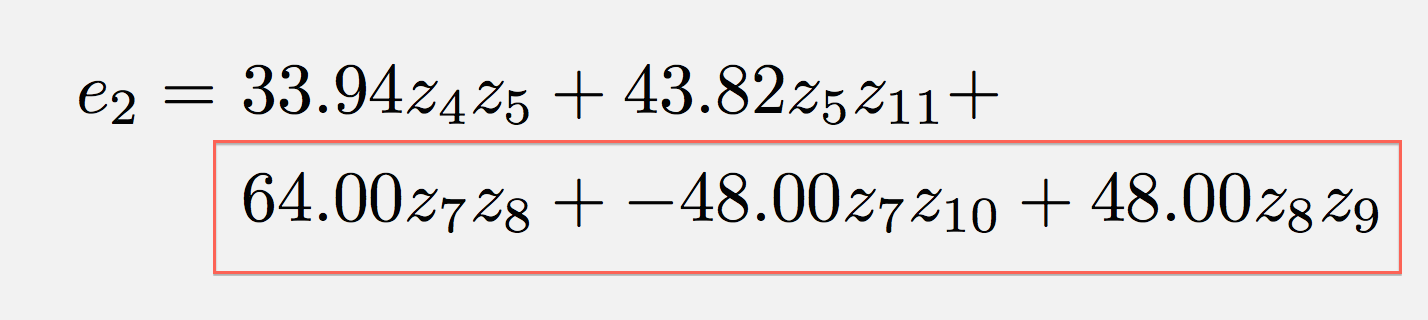

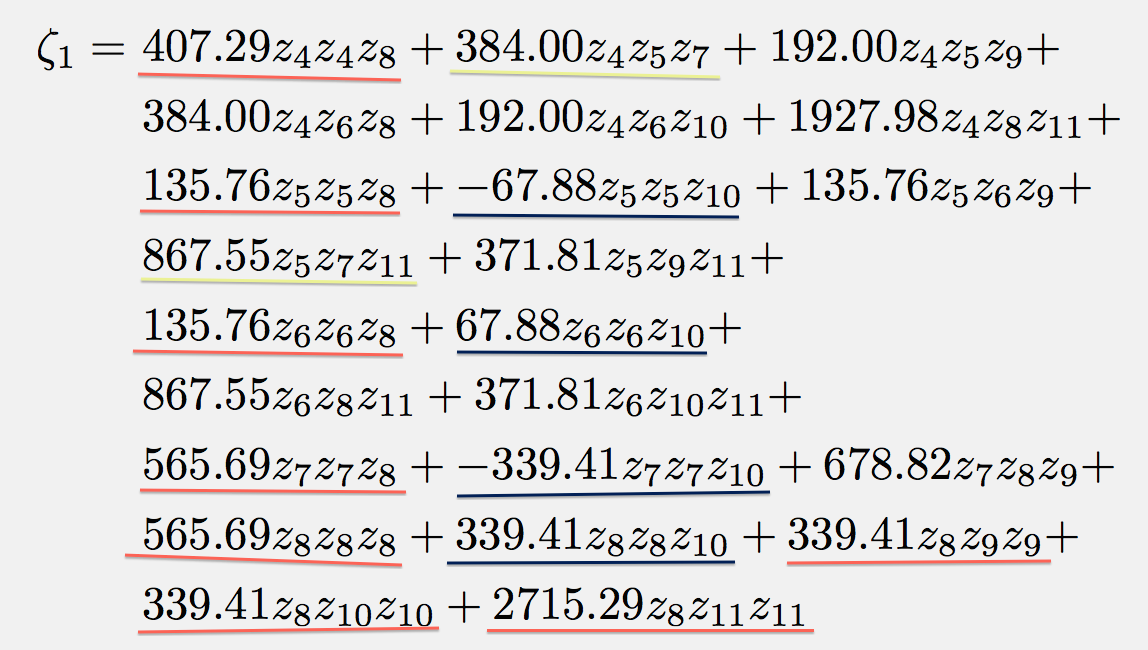

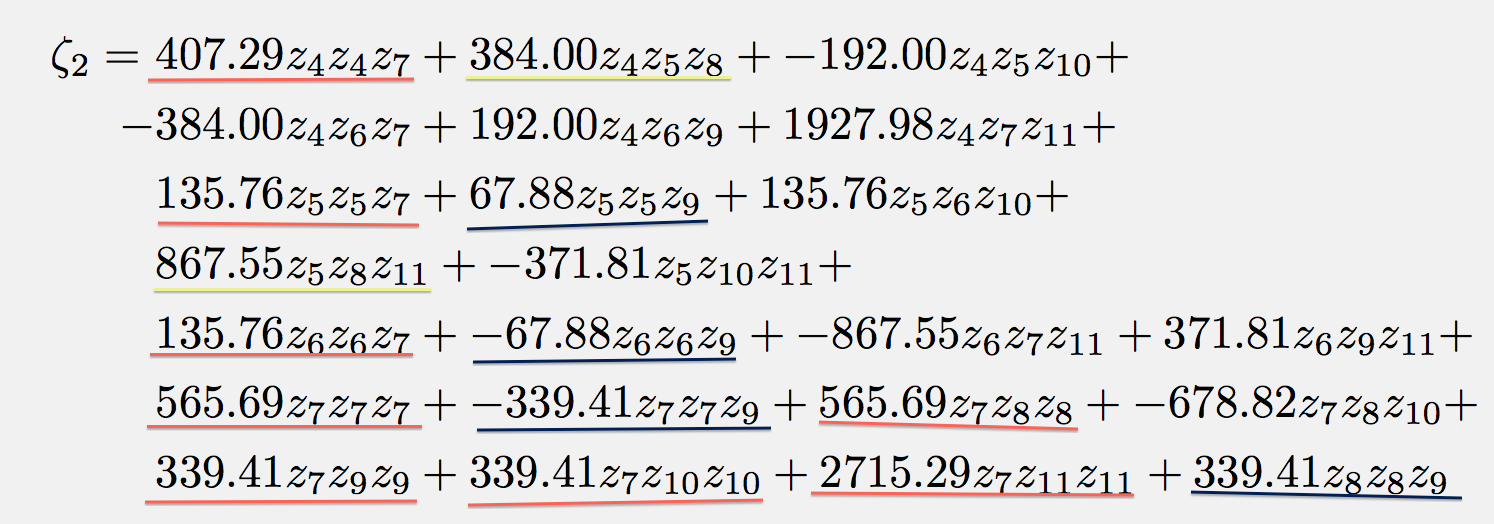

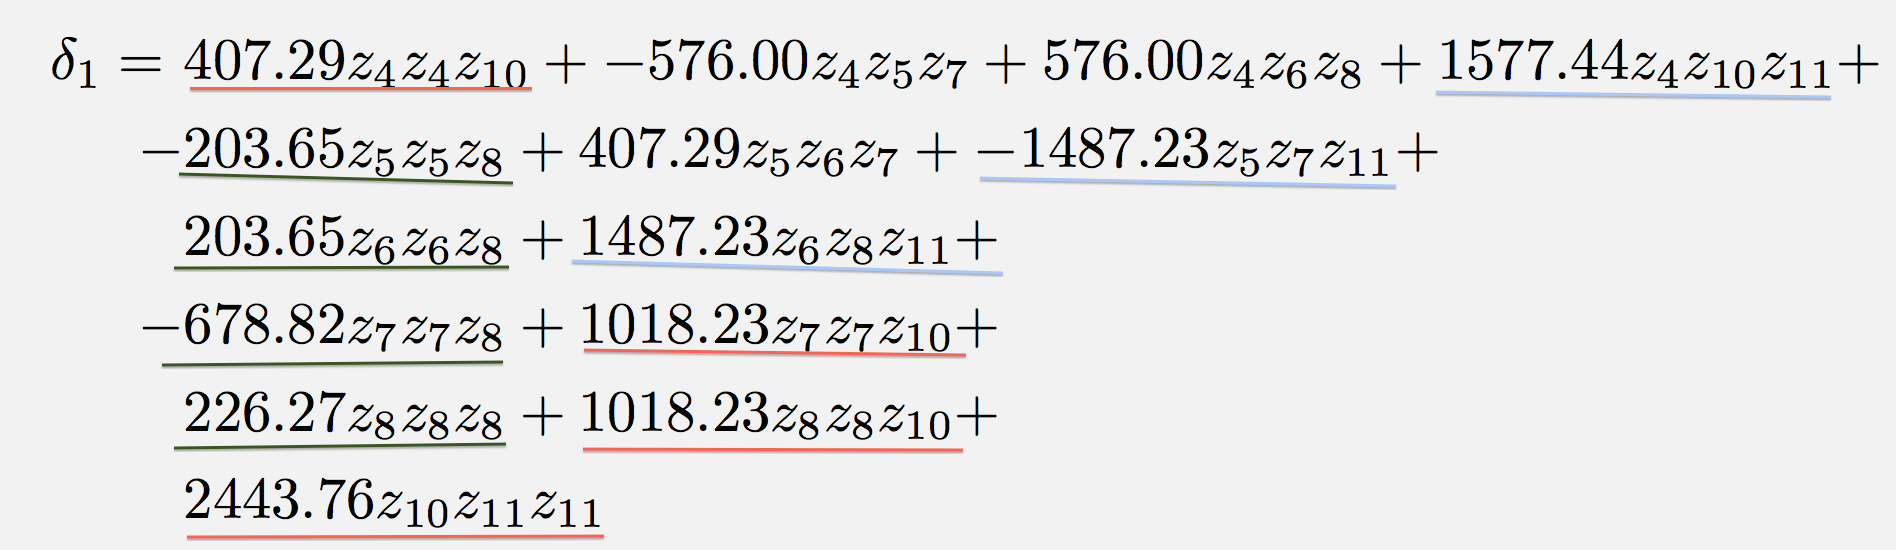

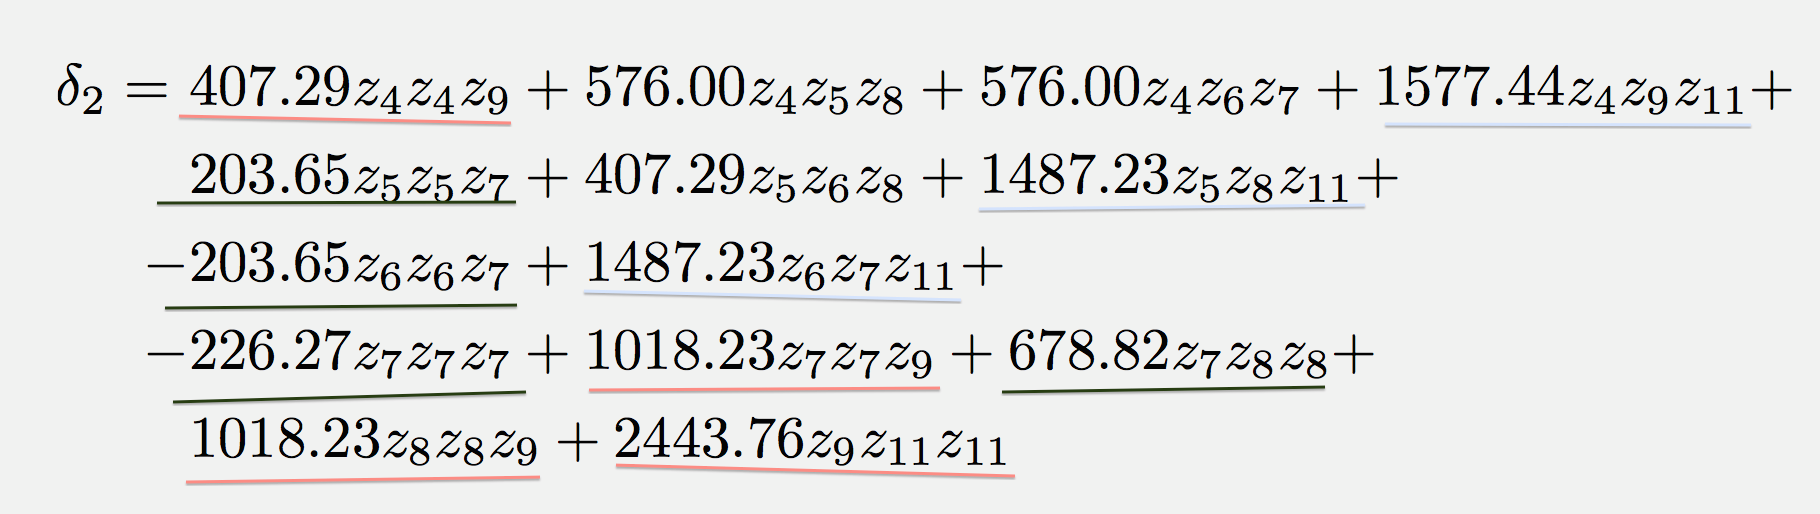

In [33]:
# or in terms of zernikes:
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/e0.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/e1.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/e2.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/zeta1.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/zeta2.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/delta1.png', height=200))
display(Image(filename='/Users/cpd/Projects/WavefrontPSF/Images/delta2.png', height=200))

So what to do?

These relationships should hold up to some sort of multiplicative constant for ALL the parameters. Additionally, we expect that terms not specified here should be somewhat minimal. We can measure precisely how minimal they are later.

Plan is this:

- Figure out relationship at constant rzero
- Figure out how varying rzero changes a given parameter
  - hopefully determine a way to parameterize this effect? Linear, etc? Independent of zernike?
- Figure out how moving in x changes parameter, and y, and if the two are the same or not.
  - hopefully determine a way to parameterize this effect? Linear, etc? Independent of zernike?

In [6]:
from WavefrontPSF.wavefront import shiftedColorMap
def evaluate_zernikes(zernikes, wf=WF, x=0, y=0, rzero=0.14):
    stamps = []
    for inputZernikeArray in zernikes:
        stamp = wf.draw_donut(x, y, inputZernikeArray, rzero)
        stamps.append(stamp)
    stamps = np.array(stamps)
    evaluated_psfs = wf.PSF_Evaluator(stamps)
    return evaluated_psfs

def plot_twod(xkey, ykey, zkey, data,
              reducer=np.median, num_bins=10,
              fig=None, ax=None):
    x = data[xkey]
    y = data[ykey]
    z = data[zkey]
    bins_x = np.linspace(np.min(x), np.max(x), num_bins)
    bins_y = np.linspace(np.min(y), np.max(y), num_bins)
    groups = data.groupby([pd.cut(x, bins_x), pd.cut(y, bins_y)])
    field = groups.aggregate(reducer)
    # filter out nanmins on x and y
    field = field[field[xkey].notnull() &
                  field[ykey].notnull() &
                  field[zkey].notnull()]
    zfield = field[zkey][field[zkey].notnull()]
    
    indx_x = field.index.labels[0].values()
    indx_y = field.index.labels[1].values()
    # here is something that is going to be irritating and cludgey:
    # let's get the values of the different bins (for sorting purposes)
    x_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in field.index.levels[0]])
    y_vals = np.array([np.mean(eval(ith.replace('(','['))) for
                       ith in field.index.levels[1]])
    # now sort the order for the levels
    x_vals_argsorted = np.argsort(x_vals)
    y_vals_argsorted = np.argsort(y_vals)
    # now this means that the 0th entry in x_vals_argsorted comes first
    # so we want indx_x_transform to represent the sorted values
    # so instead of indx_x representing arbitrary bin i, we want it to
    # instead represent sorted bin j
    indx_x_transform = np.argsort(np.arange(len(x_vals))[np.argsort(x_vals)])[indx_x]
    indx_y_transform = np.argsort(np.arange(len(y_vals))[np.argsort(y_vals)])[indx_y]

    if ax == None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax.set_xlabel(xkey)
        ax.set_ylabel(ykey)

    # figure out shifting the colormap
    b = np.max(zfield)
    a = np.min(zfield)
    c = 0
    midpoint = (c - a) / (b - a)
    if midpoint <= 0:
        cmap = plt.cm.Reds
    else:
        cmap = shiftedColorMap(plt.cm.RdBu_r, midpoint=midpoint)
    vmin = a
    vmax = b

    C = np.ma.zeros((indx_x.max() + 1, indx_y.max() + 1))
    C.mask = np.ones((indx_x.max() + 1, indx_y.max() + 1))
    np.add.at(C, [indx_x_transform, indx_y_transform],
              zfield.values)
    np.multiply.at(C.mask, [indx_x_transform, indx_y_transform], 0)
    # bloops
    C = C.T

    IM = ax.pcolor(bins_x, bins_y, C,
                   cmap=cmap, vmin=vmin, vmax=vmax)
    CB = fig.colorbar(IM, ax=ax)
    CB.ax.set_ylabel(zkey, rotation=270)
    
#     # look at scatter plots
#     ax = axes[1]
#     ax.set_xlabel(xkey)
#     ax.set_ylabel(zkey)
#     IM = ax.scatter(x, z, marker='o', c=y, cmap=plt.cm.RdBu_r, linewidth=0.5, alpha=0.5)
#     CB = fig.colorbar(IM, ax=ax)
#     CB.ax.set_ylabel(ykey, rotation=270)

#     ax = axes[2]
#     ax.set_xlabel(ykey)
#     ax.set_ylabel(zkey)
#     IM = ax.scatter(y, z, marker='o', c=x, cmap=plt.cm.RdBu_r, linewidth=0.5, alpha=0.5)
#     CB = fig.colorbar(IM, ax=ax)
#     CB.ax.set_ylabel(xkey, rotation=270)

    return fig, ax

def plot_combo_2d(xkey, ykey, zkey, data,
                  reducer=np.median, num_bins=10,
                  fig=None, ax=None):
    
    if ax == None:
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,5 * 3))
        
        
    ax = axes[0]
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    fig, ax = plot_twod(xkey, ykey, zkey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[1]
    ax.set_xlabel(xkey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(xkey, zkey, ykey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    ax = axes[2]
    ax.set_xlabel(ykey)
    ax.set_ylabel(zkey)
    fig, ax = plot_twod(ykey, zkey, xkey, data,
              reducer=reducer, num_bins=num_bins,
              fig=fig, ax=ax)
    
    return fig, axes

In [7]:
# just vary rzero

zis = [-0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4]
psfsss = []

for zi in zis:
    rzeros = np.linspace(0.1, 0.25, 11)
    xkey = 'rzero'
    stamps = []
    x = 0
    y = 0
    inputZernikeArray = np.zeros(11)
    inputZernikeArray[3] = zi
    inputZernikeArray[6:8] = zi
    for rzero in rzeros:
        stamp = WF.draw_donut(x, y, inputZernikeArray, rzero)
        stamps.append(stamp)
    stamps = np.array(stamps)
    psfs = WF.PSF_Evaluator(stamps)
    psfsss.append(psfs)

zkeys = ['e0', 'e1', 'e2', 'zeta1', 'zeta2', 'delta1', 'delta2']
fig, axes = plt.subplots(ncols=len(zkeys), figsize=(3 * len(zkeys) * 1.3, 3))
for zkey_i, zkey in enumerate(zkeys):
    ax = axes[zkey_i]
    x = rzeros
    for psfs_i, psfs in enumerate(psfsss):
        z = psfs[zkey]
        ax.plot(x, z, 'o', label='{0}'.format(zis[psfs_i]), alpha=0.5)

    ax.set_xlabel(xkey)
    ax.set_ylabel(zkey)
plt.legend()
plt.tight_layout()

AttributeError: 'DECAM_Model_Wavefront' object has no attribute 'draw_donut'

In [1]:
# one d
zi = 4
for zi in range(4, 12):
    xkey = 'z{0}'.format(zi)

    zmax = 0.5
    dz = 0.1
    range_zernikes = np.arange(-zmax, zmax + dz, dz)
    zernikes = []
    for zernike_i in range_zernikes:
        zernike = [0] * 11
        zernike[4-1] = 0.2
        zernike[zi - 1] = zernike_i
        zernikes.append(zernike)
    zernikes = np.array(zernikes)

    psfs = evaluate_zernikes(zernikes)
    for zk in xrange(1, 12):
        psfs['z{0}'.format(zk)] = zernikes[:, zk - 1]

    zkeys = ['e0', 'e1', 'e2', 'zeta1', 'zeta2', 'delta1', 'delta2']
    fig, axes = plt.subplots(ncols=len(zkeys), figsize=((3 * len(zkeys) * 1.3, 3)))
    for zkey_i, zkey in enumerate(zkeys):
        ax = axes[zkey_i]
        x = psfs[xkey]
        z = psfs[zkey]

        ax.set_xlabel(xkey)
        ax.set_ylabel(zkey)
        ax.plot(x, z, 'o')
    plt.tight_layout()

NameError: name 'evaluate_zernikes' is not defined

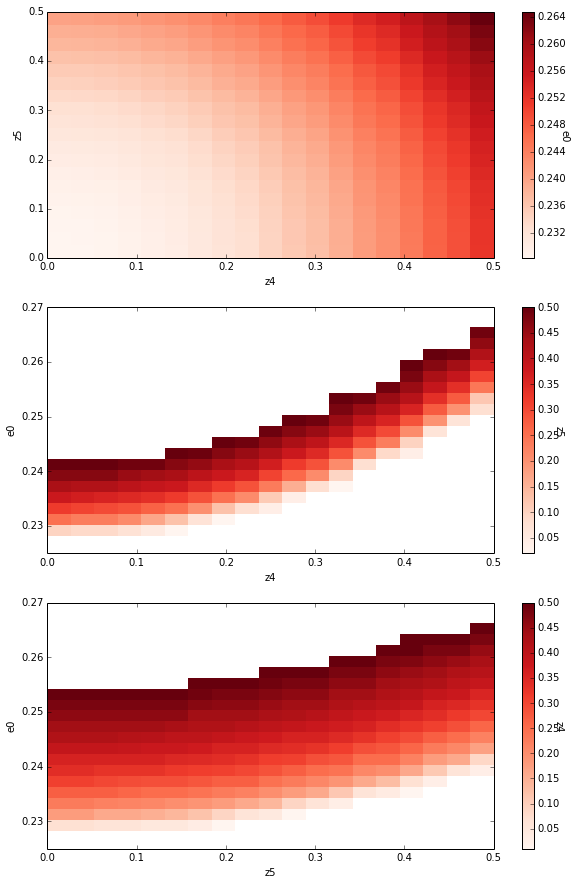

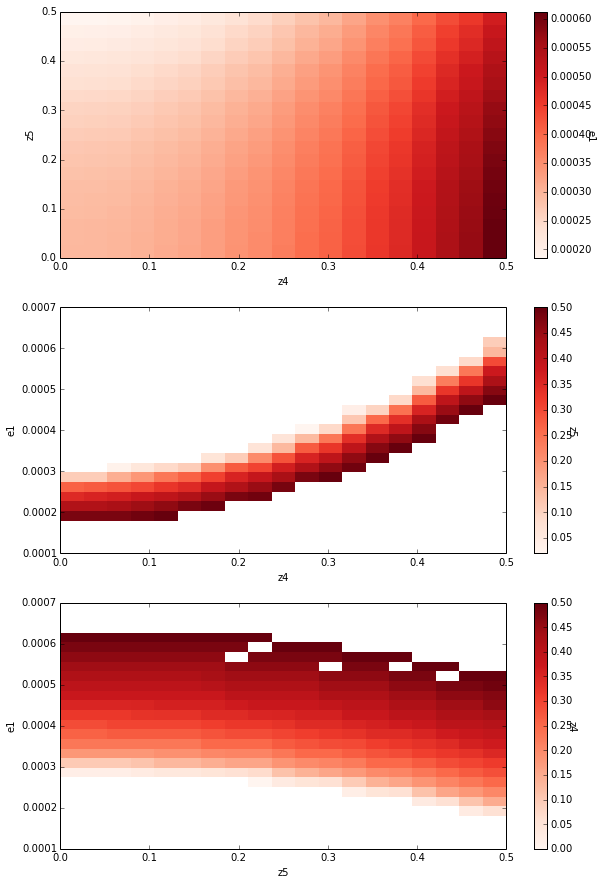

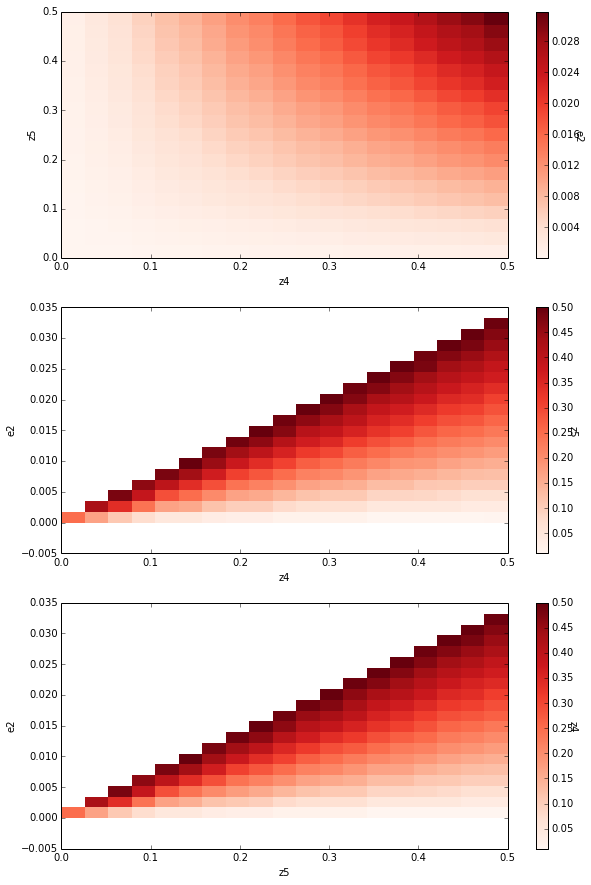

In [95]:
# two d
zi = 4
xkey = 'z{0}'.format(zi)
zj = 5
ykey = 'z{0}'.format(zj)

zmax = 0.5
dz = 0.02
range_zernikes = np.arange(0, zmax + dz, dz)
zernikes = []
for zernike_i in range_zernikes:
    for zernike_j in range_zernikes:
        zernike = [0] * 11
#         zernike[4-1] = 0.5
        zernike[zi - 1] = zernike_i
        zernike[zj - 1] = zernike_j
        zernikes.append(zernike)
zernikes = np.array(zernikes)

psfs = evaluate_zernikes(zernikes)
for zk in xrange(1, 12):
    psfs['z{0}'.format(zk)] = zernikes[:, zk - 1]
    
for zkey in ['e0', 'e1', 'e2']:#, 'zeta1', 'zeta2', 'delta1', 'delta2']:
    plot_combo_2d(xkey, ykey, zkey, psfs, reducer=np.mean, num_bins=20)

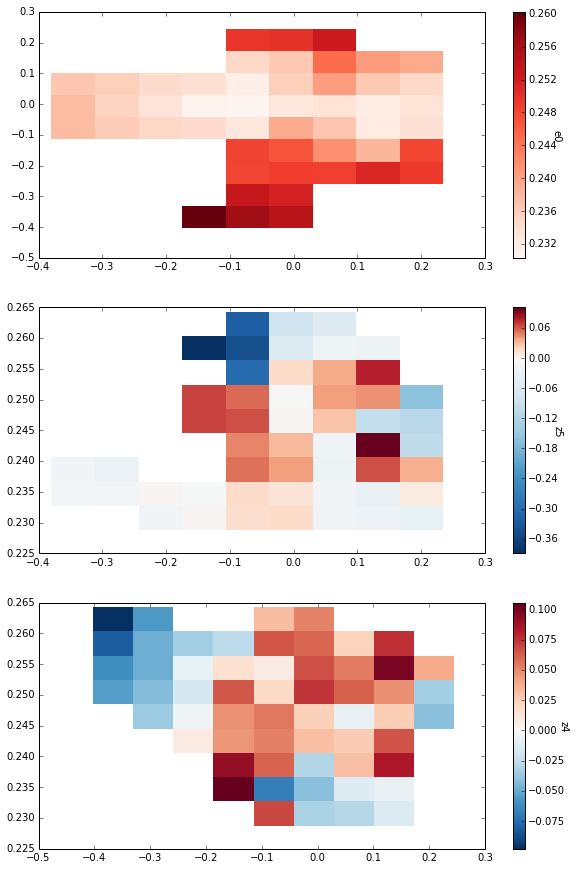

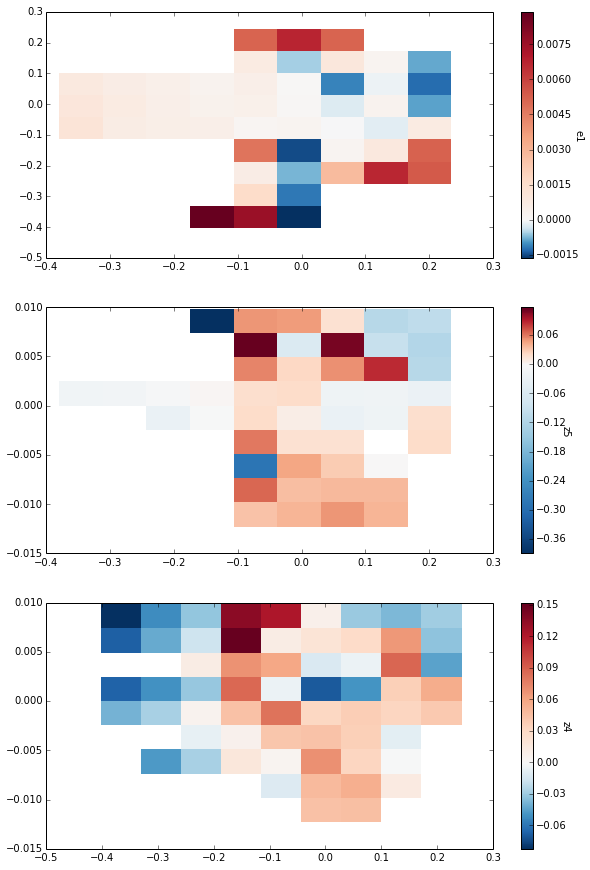

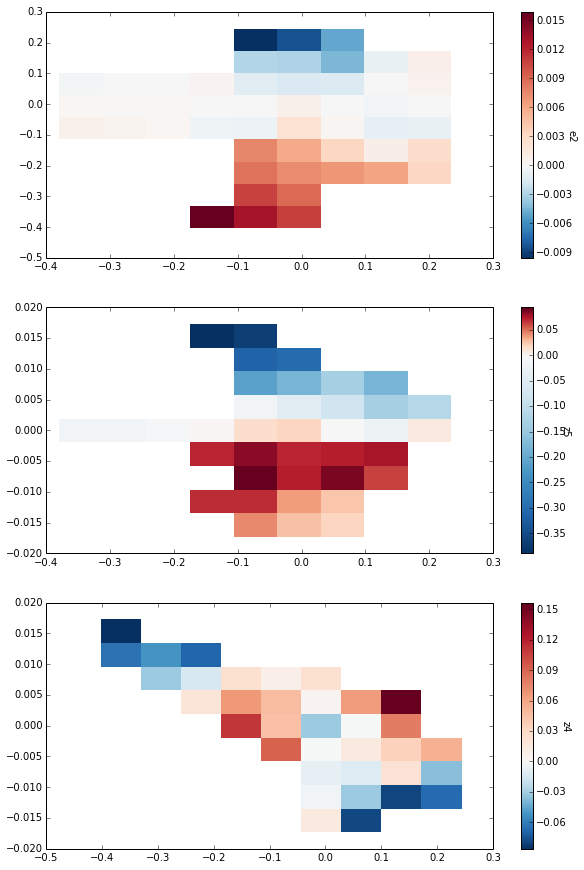

In [79]:
zi = 4
xkey = 'z{0}'.format(zi)
zj = 5
ykey = 'z{0}'.format(zj)

for zkey in ['e0', 'e1', 'e2']:#, 'zeta1', 'zeta2', 'delta1', 'delta2']:
    plot_combo_2d(xkey, ykey, zkey, WF.data)